In [1]:
!gdown --id 1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf


/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Q6pdhzWFu2oegWMPvrOE8dWTra8FJsTf
To: /content/Mall_Customers.csv
100% 3.98k/3.98k [00:00<00:00, 11.7MB/s]


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Load the dataset
file_path = '/content/Mall_Customers.csv'
df = pd.read_csv(file_path)

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [4]:
# Replace '?' with NaN for handling missing values
df.replace(' ?', pd.NA, inplace=True)

# Drop rows with missing values
df.dropna(inplace=True)

# Drop the 'income' column as it is not needed for unsupervised learning
df_unsupervised = df.drop(columns=['Annual Income (k$)'])

# Split the features into categorical and numerical
categorical_features = df_unsupervised.select_dtypes(include=['object']).columns
numerical_features = df_unsupervised.select_dtypes(include=['int64', 'float64']).columns

# Standard scaling for numerical features only
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(df_unsupervised[numerical_features])

# One-hot encoding for categorical features only
encoder = OneHotEncoder(drop='first')
encoded_categorical_data = encoder.fit_transform(df_unsupervised[categorical_features])

# Concatenate the scaled numerical and encoded categorical data
processed_data = np.hstack([scaled_numerical_data, encoded_categorical_data.toarray()])

# Convert to DataFrame with appropriate column names
final_columns = numerical_features.tolist() + encoder.get_feature_names_out(categorical_features).tolist()
final_df = pd.DataFrame(processed_data, columns=final_columns)

final_df.to_csv('processed_data.csv', index=False)

final_df.head()


,CustomerID,Age,Spending Score (1-100),Gender_Male
0,-1.723412,-1.424569,-0.434801,1.0
1,-1.706091,-1.281035,1.195704,1.0
2,-1.688771,-1.352802,-1.715913,0.0
3,-1.671450,-1.137502,1.040418,0.0
4,-1.654129,-0.563369,-0.395980,0.0


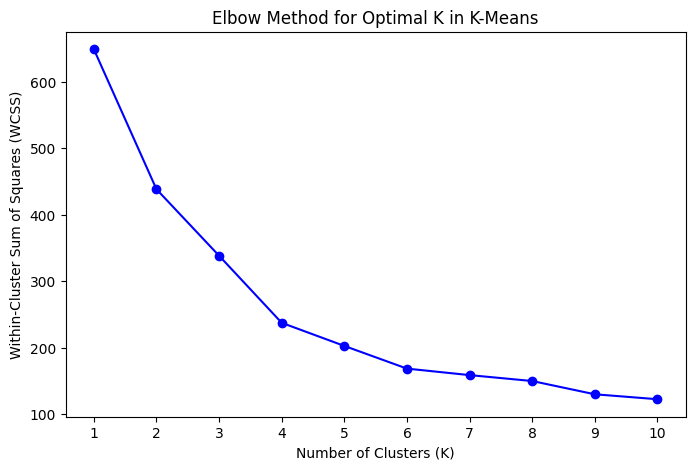

In [5]:
# Calculate WCSS for a range of K values to use the Elbow Method
wcss = []
k_range = range(1, 11)  # Range of K values from 1 to 10

# Iterate through each k and calculate WCSS
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(final_df)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title("Elbow Method for Optimal K in K-Means")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.xticks(k_range)
plt.show()


In [6]:
# Define number of clusters for K-Means
n_clusters = 6

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
final_df['KMeans_Cluster'] = kmeans.fit_predict(final_df)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
final_df['DBSCAN_Cluster'] = dbscan.fit_predict(final_df)

# PCA for 2D visualization
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster']))
final_df['PCA1'] = pca_result[:, 0]
final_df['PCA2'] = pca_result[:, 1]

# Calculate evaluation scores
data = final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2'])
silhouette_kmeans = silhouette_score(data,
                                     final_df['KMeans_Cluster'])
silhouette_dbscan = silhouette_score(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2']),
                                     final_df['DBSCAN_Cluster'])
dbi_kmeans = davies_bouldin_score(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2']),
                                  final_df['KMeans_Cluster'])
dbi_dbscan = davies_bouldin_score(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2']),
                                  final_df['DBSCAN_Cluster'])

# Print evaluation scores
print(f"Silhouette Score (K-Means): {silhouette_kmeans}")
print(f"Silhouette Score (DBSCAN): {silhouette_dbscan}")
print(f"Davies-Bouldin Index (K-Means): {dbi_kmeans}")
print(f"Davies-Bouldin Index (DBSCAN): {dbi_dbscan}")




Silhouette Score (K-Means): 0.3756551260207429
Silhouette Score (DBSCAN): -0.016767154317014223
Davies-Bouldin Index (K-Means): 1.0039360640641324
Davies-Bouldin Index (DBSCAN): 1.4507842781814715


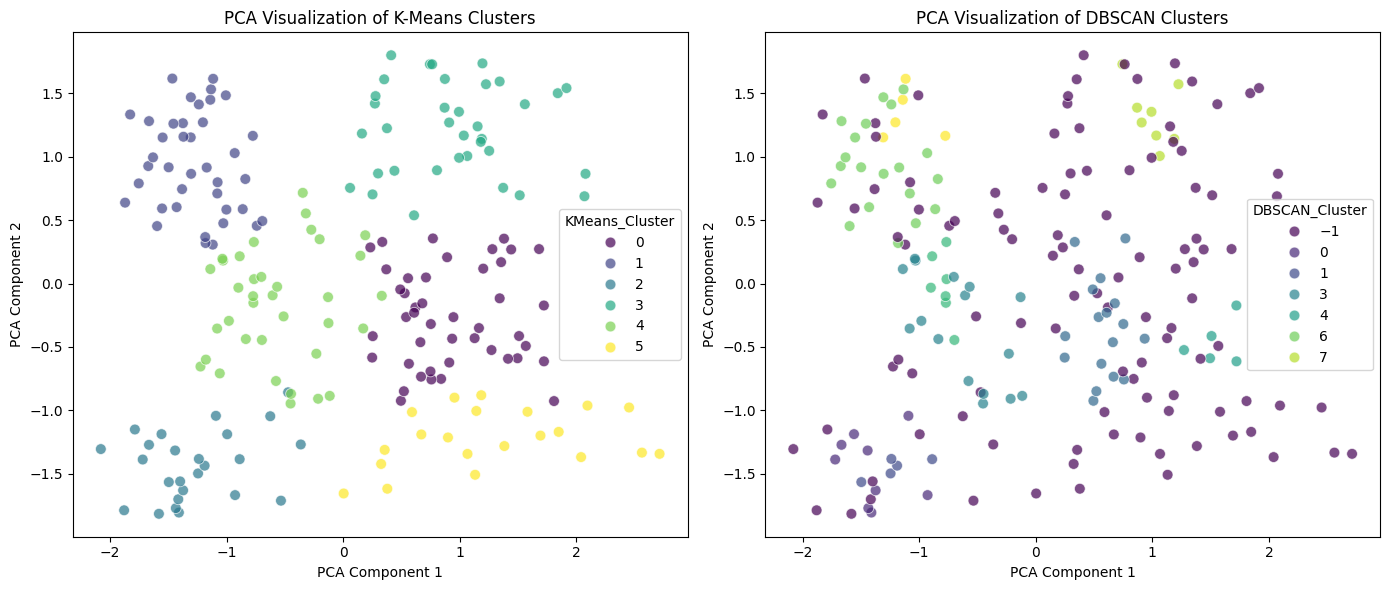

In [7]:
# Plot PCA visualization for K-Means and DBSCAN clusters
plt.figure(figsize=(14, 6))

# Plot for K-Means
plt.subplot(1, 2, 1)
sns.scatterplot(data=final_df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of K-Means Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot for DBSCAN
plt.subplot(1, 2, 2)
sns.scatterplot(data=final_df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of DBSCAN Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


Silhouette Score (GMM): 0.3655999325212314
Davies-Bouldin Index (GMM): 1.0181650395836515


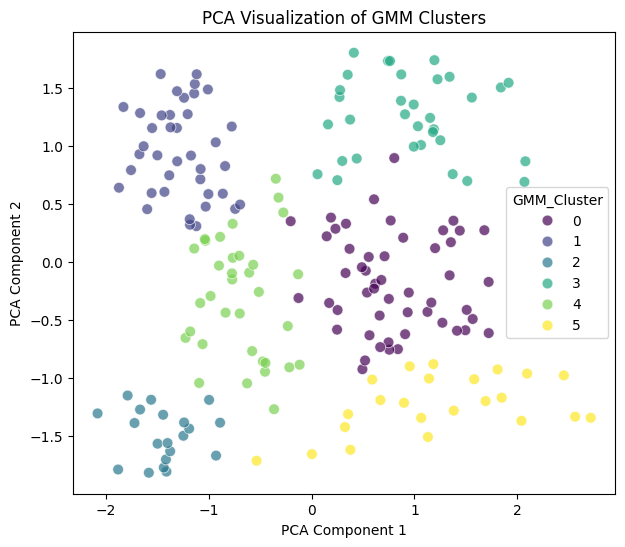

In [8]:
from sklearn.mixture import GaussianMixture

# Apply Gaussian Mixture Model with the same number of clusters as K-Means (6 clusters)
gmm = GaussianMixture(n_components=6, random_state=42)
final_df['GMM_Cluster'] = gmm.fit_predict(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'PCA1', 'PCA2']))

# Calculate silhouette and Davies-Bouldin scores for GMM
silhouette_gmm = silhouette_score(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster', 'PCA1', 'PCA2']),
                                  final_df['GMM_Cluster'])
dbi_gmm = davies_bouldin_score(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster', 'PCA1', 'PCA2']),
                               final_df['GMM_Cluster'])

# Print the evaluation scores for GMM
print(f"Silhouette Score (GMM): {silhouette_gmm}")
print(f"Davies-Bouldin Index (GMM): {dbi_gmm}")

# PCA visualization for GMM clusters
plt.figure(figsize=(7, 6))
sns.scatterplot(data=final_df, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("PCA Visualization of GMM Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


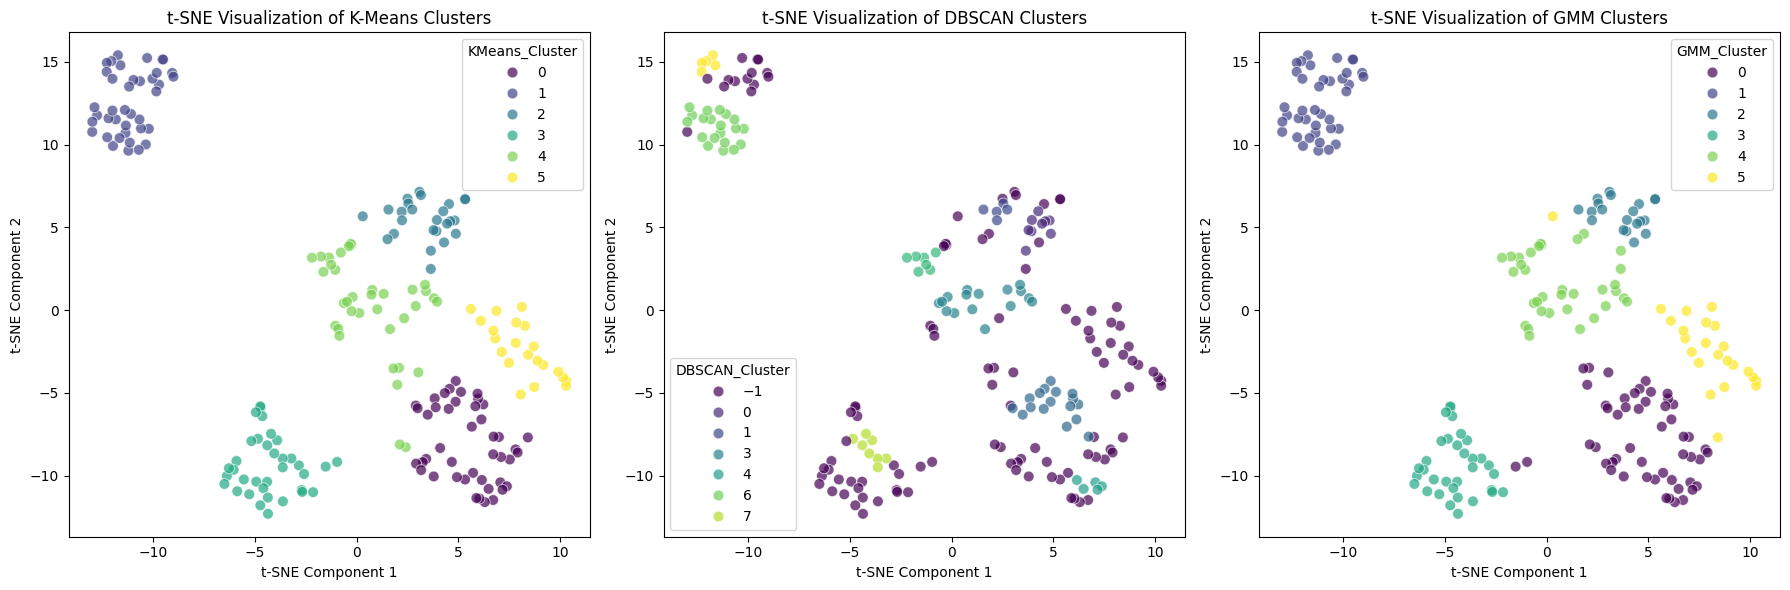

In [9]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(final_df.drop(columns=['KMeans_Cluster', 'DBSCAN_Cluster', 'GMM_Cluster', 'PCA1', 'PCA2']))


# Add t-SNE results to the DataFrame
final_df['tSNE1'] = tsne_result[:, 0]
final_df['tSNE2'] = tsne_result[:, 1]

# Plot t-SNE visualization for K-Means, DBSCAN, and GMM clusters
plt.figure(figsize=(18, 6))

# Plot for K-Means
plt.subplot(1, 3, 1)
sns.scatterplot(data=final_df, x='tSNE1', y='tSNE2', hue='KMeans_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Visualization of K-Means Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Plot for DBSCAN
plt.subplot(1, 3, 2)
sns.scatterplot(data=final_df, x='tSNE1', y='tSNE2', hue='DBSCAN_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Visualization of DBSCAN Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Plot for GMM
plt.subplot(1, 3, 3)
sns.scatterplot(data=final_df, x='tSNE1', y='tSNE2', hue='GMM_Cluster', palette='viridis', s=60, alpha=0.7)
plt.title("t-SNE Visualization of GMM Clusters")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()
